In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from systems import BicycleModel
from trajectory import compute_circle_start_on_circle, wrap_circular_value

In [28]:
def ctrl_linear(state:np.ndarray,
                state_d:np.ndarray,params) -> np.ndarray:

    p_I_x, p_I_y, theta, v_B_x, v_B_y, omega = state
    p_d_I_x, p_d_I_y, theta_d, v_d_I_x, v_d_I_y, omega_d = state_d

    p_I = np.array([p_I_x, p_I_y]) # Positions in the inertial frame.
    p_d_I = np.array([p_d_I_x, p_d_I_y]) # Desired positions in the inertial frame.
    v_d_I = np.array([v_d_I_x, v_d_I_y]) # Desired velocities in the inertial frame.

    p_err_I = p_I - p_d_I # Position error in the inertial frame.
    R_d = np.array([[np.cos(theta_d), -np.sin(theta_d)],
                    [np.sin(theta_d), np.cos(theta_d)]])
    R = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    
    perr_B = R.T @ p_err_I
    perr_d_B = R_d.T @ p_err_I
    v_d_B = R_d.T @ v_d_I

    # e1.
    e_perp = perr_d_B[1]
    # e1_dot.
    e_perp_dot = v_B_y + v_B_x * wrap_circular_value(theta - theta_d)
    # e2.
    theta_err = wrap_circular_value(theta - theta_d)
    # e2_dot.
    omega_err = omega - omega_d

    ###
    # Add the u_steering calculation here as a feedback on e_perp, e_perp_dot, theta_err, omega_err.
    # Do not forget to clip the steering angle between u_steering_min and u_steering_max.
    # Do not forget to clamp the integral gain for adaptation.
    # u_steering = ...
    MAX_STEERING = np.deg2rad(20)
    MAX_VEL = 10.0

    K_s  = np.array([3, 2, 2.5, 0.5] )

    u_steering_d =  - K_s @ np.array([e_perp, e_perp_dot, theta_err, omega_err])
    #u_steering_d = np.clip(u_steering_d, -MAX_STEERING, MAX_STEERING)

    #u_steering_d = 0
    u_feedforward  = np.arctan(params["L"]/2/ 2.2)

     
    u_steering = u_steering_d + u_feedforward

    u_steering = np.clip(u_steering, -MAX_STEERING, MAX_STEERING) 

    ###
    # Add the u_v calculation here from Problem Set 5
    # Do not forget to clip u_v.
    kp = 1.0
    tau = 0.1
    b = 1/tau
    a = -1/tau
    
    u_v = -1/b*(kp * (v_B_x - v_d_B[0]) + a * v_d_B[0])
    u_v = np.clip(u_v, -MAX_VEL, MAX_VEL)
    ###
    
    # Debug params.
    outputs = {
        'e_perp': e_perp,
        'e_perp_dot': e_perp_dot,
        'theta_err': theta_err,
        'omega_err': omega_err,
        'v_d_B_x': v_d_B[0],
        'v_d_B_y': v_d_B[1],
    }

    return np.array([u_v, u_steering]), outputs


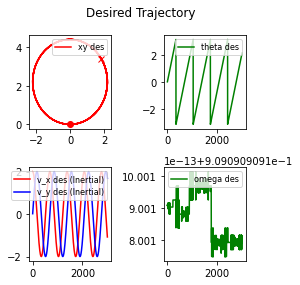

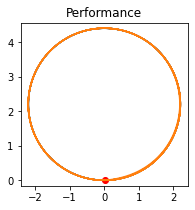

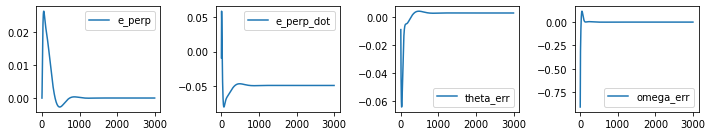

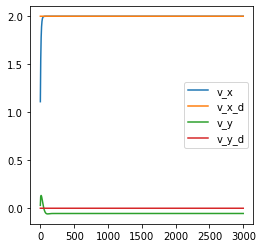

In [29]:
# Simulation parameters
N = 3000
DT = 0.01

# Model params.
params = {"dt": DT,
            "tau": 0.1,
            'L': 0.4,
            'Cy': 100,
            'mass': 11.5,
            'Iz': 0.5,
}

# Set the model.
car = BicycleModel(params)

# Des. Traj.
des_traj_array = np.empty((N, 6))
theta_d_previous = 0.0
e_perp_sum = 0.0

# Outputs dict.
output_dict_list = []
action_list = np.empty((N, 2))

angle = 0.0
state = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
state0 = state.copy()
state_array = np.empty((N, 6))


for i in range(N):
    # Compute desired trajectory.
    x_d_I, y_d_I, _, vx_d_I, vy_d_I, _, angle = compute_circle_start_on_circle(angle=angle,
                                                                               dt=DT,
                                                                               v_desired=2.0,
                                                                               initial_state_I=[state0[0], state0[1], state0[2]])
    theta_d = np.arctan2(vy_d_I, vx_d_I)
    omega_d = wrap_circular_value((theta_d - theta_d_previous)/DT)
    theta_d_previous = theta_d
    state_d = np.array([x_d_I, y_d_I, theta_d, vx_d_I, vy_d_I, omega_d])

    action, outputs = ctrl_linear(state=state,
                                  state_d=state_d,
                                  params=params)

    # Propagate.
    next_state = car.dynamics(state, action)
    state = next_state.copy()
    
    # Save data.
    des_traj_array[i, :] = state_d
    state_array[i, :] = state
    output_dict_list.append(outputs)
    action_list[i, :] = action
    

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
plt.suptitle('Desired Trajectory')
ax[0, 0].plot(des_traj_array[:, 0], des_traj_array[:, 1], 'r-', label='xy des')
ax[0, 0].plot(des_traj_array[0, 0], des_traj_array[0, 1], 'ro')
ax[0, 0].plot(des_traj_array[-1, 0], des_traj_array[-1, 1], 'rx')

ax[0, 1].plot(des_traj_array[:, 2], 'g-', label='theta des')

ax[1, 0].plot(des_traj_array[:, 3], 'r-', label='v_x des (Inertial)')
ax[1, 0].plot(des_traj_array[:, 4], 'b-', label='v_y des (Inertial)')

ax[1 ,1].plot(des_traj_array[:, 5], 'g-', label='omega des')
for i in range(2):
    for j in range(2):
        ax[i, j].legend(loc='upper right', fontsize=8)
plt.tight_layout()

plt.figure(figsize=(3, 3))
plt.plot(des_traj_array[:, 0], des_traj_array[:, 1])
plt.plot(des_traj_array[0, 0], des_traj_array[0, 1], 'ro')
plt.plot(state_array[:, 0], state_array[:, 1])
plt.axis('equal')
plt.title('Performance')

e_perp_array = np.array([output_dict['e_perp'] for output_dict in output_dict_list])
e_perp_dot_array = np.array([output_dict['e_perp_dot'] for output_dict in output_dict_list])
theta_err_array = np.array([output_dict['theta_err'] for output_dict in output_dict_list])
omega_err_array = np.array([output_dict['omega_err'] for output_dict in output_dict_list])

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
ax[0].plot(e_perp_array, label='e_perp')
ax[0].legend()
ax[1].plot(e_perp_dot_array, label='e_perp_dot')
ax[1].legend()
ax[2].plot(theta_err_array, label='theta_err')
ax[2].legend()
ax[3].plot(omega_err_array, label='omega_err')
ax[3].legend()
plt.tight_layout()

# Velocities.
v_d_x = np.array([output_dict['v_d_B_x'] for output_dict in output_dict_list])
v_d_y = np.array([output_dict['v_d_B_y'] for output_dict in output_dict_list])
plt.figure(figsize=(4, 4))
plt.plot(state_array[:, 3], label='v_x')
plt.plot(v_d_x, label='v_x_d')
plt.plot(state_array[:, 4], label='v_y')
plt.plot(v_d_y, label='v_y_d')
plt.legend()

plt.show()


In [30]:
print("e1 final: ", e_perp_array[-1])
print("e2 final: ", theta_err_array[-1])

e1 final:  0.00010626611448490142
e2 final:  0.002709818088322713


In [22]:
np.arctan(0.4/2/2.2)

0.09065988720074511